<a href="https://colab.research.google.com/github/Saul-Ochoa/Time-Series/blob/main/Sarimax/Gasolinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consumo Mensual Gasolina**

In [46]:
pip install skforecast

  Using cached skforecast-0.10.1-py3-none-any.whl (397 kB)
  Using cached tqdm-4.65.2-py3-none-any.whl (77 kB)
  Using cached optuna-3.2.0-py3-none-any.whl (390 kB)
  Using cached alembic-1.12.1-py3-none-any.whl (226 kB)
  Using cached cmaes-0.10.0-py3-none-any.whl (29 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Librerias pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# skforecast

from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax,grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

# **Analisis Exploratorio**

In [70]:
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv'
)

df=pd.read_csv(url,sep=',')
df.head()

,Fecha,GLPs,Gasolinas,Querosenos,Gasoleos,Fueloleos
0,1969-01-01,133615.09620,166875.2129,123257.8090,401185.2939,912583.4202
1,1969-02-01,126748.47410,155466.8105,114682.5767,385360.0381,851877.8115
2,1969-03-01,107795.80910,184983.6699,109970.0796,418955.5808,873884.2933
3,1969-04-01,96683.15967,202319.8164,108797.9255,438975.5445,755490.1170
4,1969-05-01,79506.23804,206259.1523,103554.0784,467451.9469,729963.6009


In [71]:
print('Tamaño de filas y columnas :', df.shape)
print(df.info())

Tamaño de filas y columnas : (644, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fecha       644 non-null    object 
 1   GLPs        644 non-null    float64
 2   Gasolinas   644 non-null    float64
 3   Querosenos  644 non-null    float64
 4   Gasoleos    644 non-null    float64
 5   Fueloleos   644 non-null    float64
dtypes: float64(5), object(1)
memory usage: 30.3+ KB
None


In [72]:
df.isnull().sum()

Fecha         0
GLPs          0
Gasolinas     0
Querosenos    0
Gasoleos      0
Fueloleos     0
dtype: int64

In [73]:
df['Fecha']=pd.to_datetime(df['Fecha'],format='%Y-%m-%d')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Fecha       644 non-null    datetime64[ns]
 1   GLPs        644 non-null    float64       
 2   Gasolinas   644 non-null    float64       
 3   Querosenos  644 non-null    float64       
 4   Gasoleos    644 non-null    float64       
 5   Fueloleos   644 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 30.3 KB
None


In [74]:
num=df.select_dtypes(include='float64').columns
num

Index(['GLPs', 'Gasolinas', 'Querosenos', 'Gasoleos', 'Fueloleos'], dtype='object')

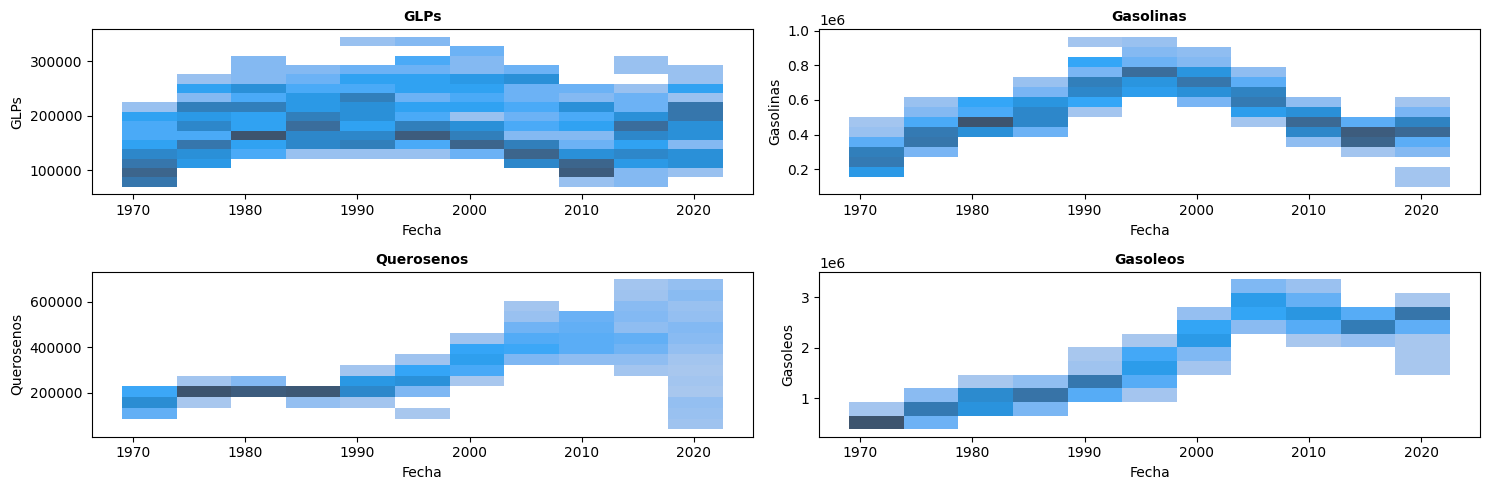

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
for i, category in enumerate(num):
    if i < 4:
        sns.histplot(data=df, x='Fecha',y=category, ax=axes[i // 2, i % 2])
        axes[i // 2, i % 2].set_title(category, fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

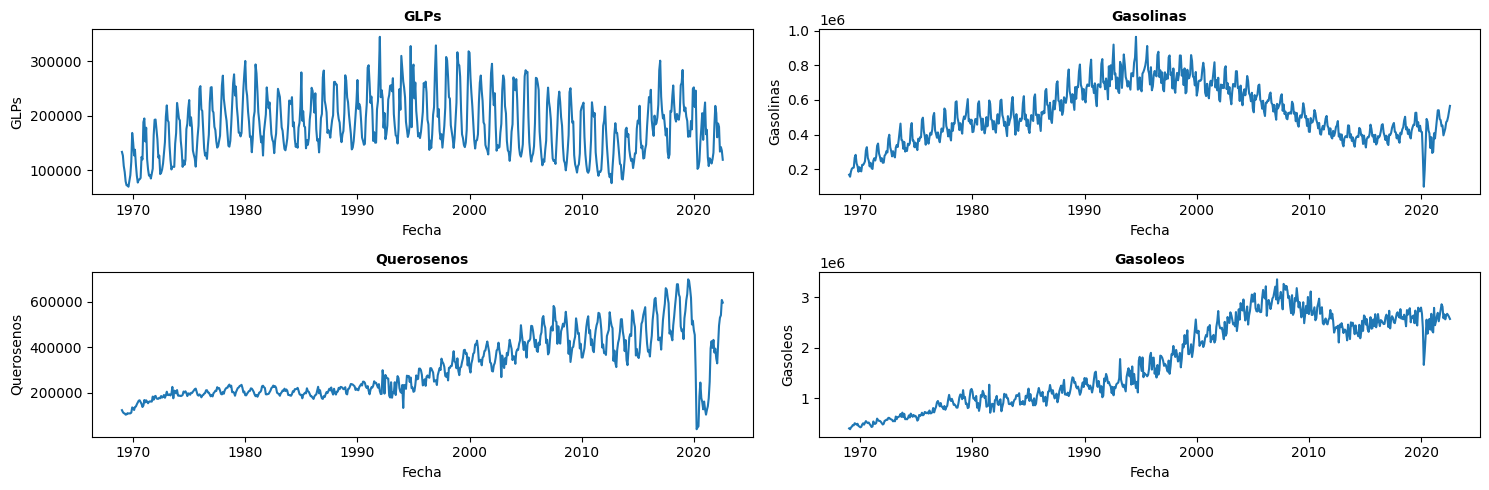

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
for i, category in enumerate(num):
    if i < 4:
        sns.lineplot(data=df, x='Fecha',y=category, ax=axes[i // 2, i % 2])
        axes[i // 2, i % 2].set_title(category, fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

In [77]:
df_new=df[['Fecha','Gasolinas']]
df_new=df_new.set_index('Fecha')
df_new= df_new.loc[:'1990-01-01 00:00:00']
df_new=df_new.asfreq('MS')
df_new.head()

,Gasolinas
Fecha,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523


In [78]:
fin_train = '1980-01-01 23:59:59'
print(f"Fechas train : {df_new.index.min()} --- {df_new.loc[:fin_train].index.max()}  (n={len(df_new.loc[:fin_train])})")
print(f"Fechas test  : {df_new.loc[fin_train:].index.min()} --- {df_new.loc[:].index.max()}  (n={len(df_new.loc[fin_train:])})")

Fechas train : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Fechas test  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


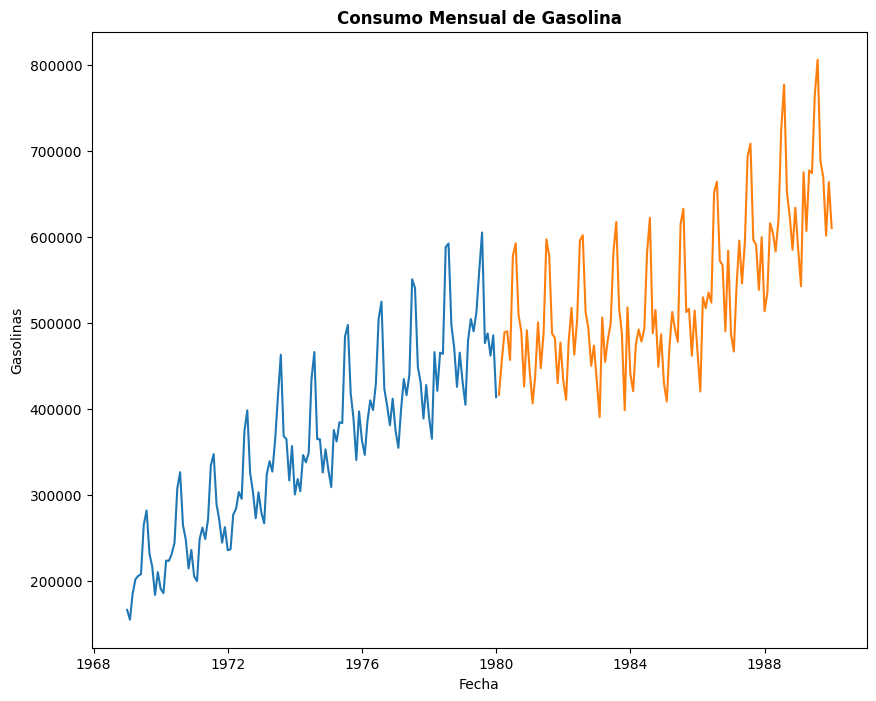

In [79]:
df_train = df_new.loc[:fin_train]
df_test  = df_new.loc[fin_train:]
plt.figure(figsize=(10,8))
sns.lineplot(data=df_train,x=df_train.index,y='Gasolinas')
sns.lineplot(data=df_test,x=df_test.index,y='Gasolinas')
plt.title('Consumo Mensual de Gasolina',fontsize=12,weight='bold')
plt.show()

In [80]:
df_diff_1=df_train.diff().dropna()
df_diff_2=df_diff_1.diff().dropna()

print('Test estacionariedad serie orignal')
print('----------------------------------')
adfuller_result=adfuller(df_new)
kpss_result=kpss(df_new)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad serie orignal
----------------------------------
ADF Statistic: -0.44612980998227997, p-value: 0.9021071923942665
KPSS Statistic: 2.2096370946978383, p-value: 0.01


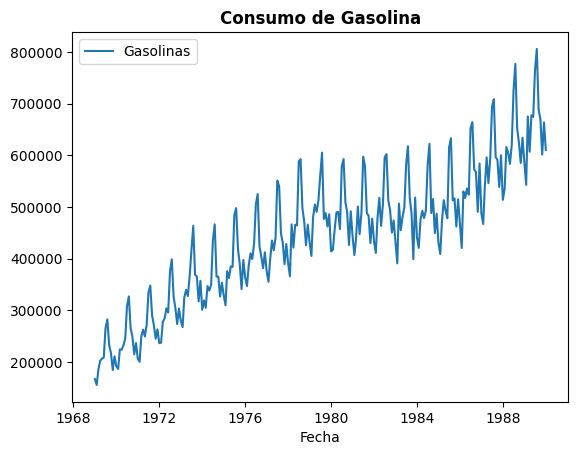

In [81]:
sns.lineplot(data=df_new)
plt.title('Consumo de Gasolina',fontsize=12,weight='bold')
plt.show()

In [82]:
print('Test estacionariedad para serie diferencia (orden=1)')
print('----------------------------------------------------')
adfuller_result=adfuller(df_diff_1)
kpss_result=kpss(df_new.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad para serie diferencia (orden=1)
----------------------------------------------------
ADF Statistic: -3.641727690032331, p-value: 0.005011605002137098
KPSS Statistic: 0.313271162357279, p-value: 0.1


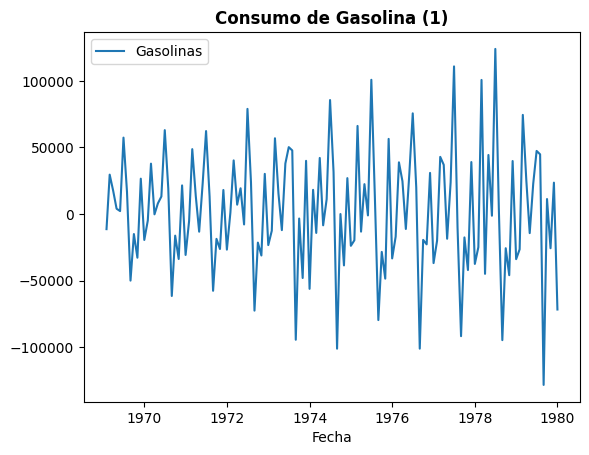

In [83]:
sns.lineplot(data=df_diff_1)
plt.title('Consumo de Gasolina (1)',fontsize=12,weight='bold')
plt.show()

In [84]:
print('Test estacionariedad para serie diferencia (orden=2)')
print('----------------------------------------------------')
adfuller_result=adfuller(df_diff_2)
kpss_result=kpss(df_new.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test estacionariedad para serie diferencia (orden=2)
----------------------------------------------------
ADF Statistic: -8.233942641656038, p-value: 5.959599575494846e-13
KPSS Statistic: 0.08065668267482215, p-value: 0.1


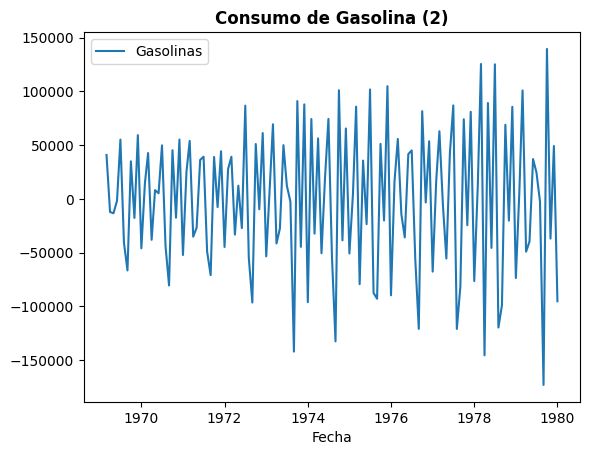

In [85]:
sns.lineplot(data=df_diff_2)
plt.title('Consumo de Gasolina (2)',fontsize=12,weight='bold')
plt.show()

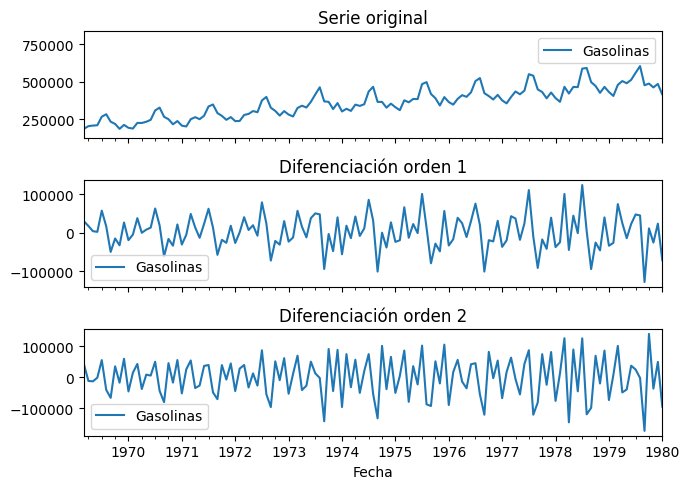

In [86]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
df_new.plot(ax=axs[0], title='Serie original')
df_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
df_diff_2.plot(ax=axs[2], title='Diferenciación orden 2')
plt.tight_layout()
plt.show()

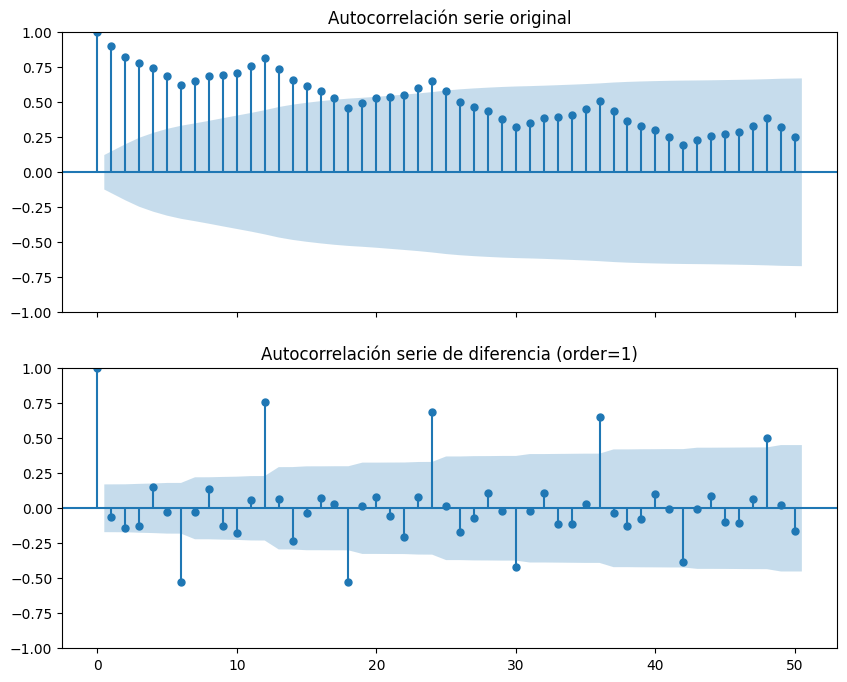

In [87]:
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
plot_acf(df_new,ax=axs[0],lags=50,alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(df_diff_1,ax=axs[1],lags=50,alpha=0.05)
axs[1].set_title('Autocorrelación serie de diferencia (order=1)')
plt.show()

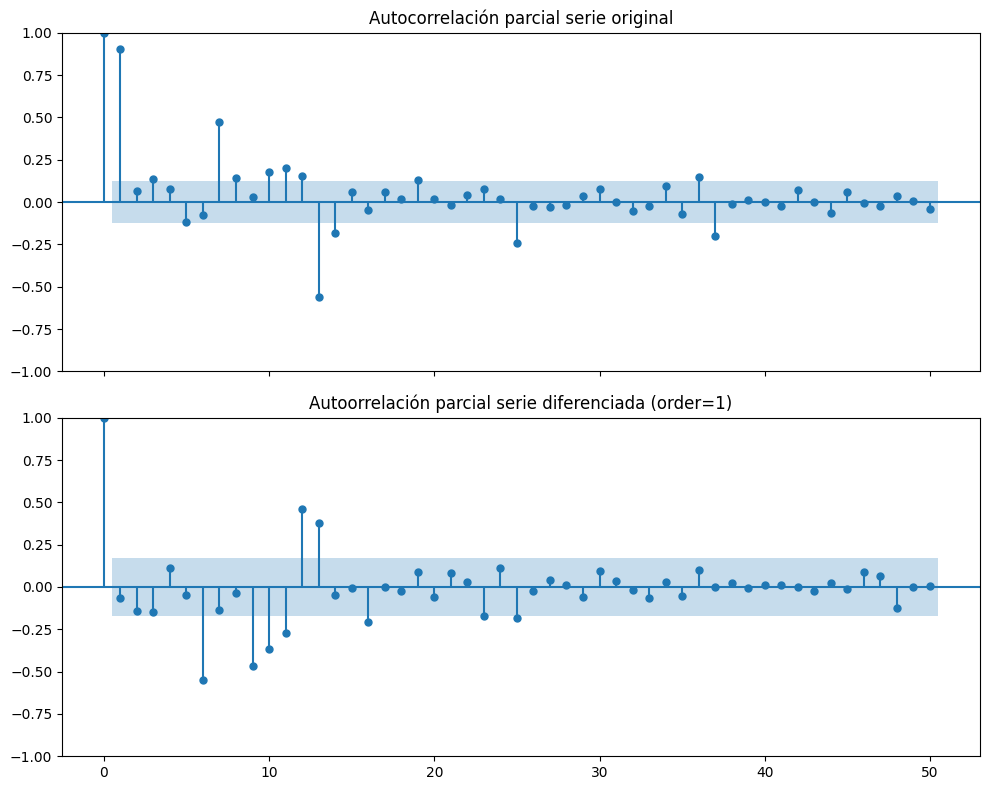

In [88]:
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
plot_pacf(df_new,ax=axs[0],lags=50,alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(df_diff_1,ax=axs[1],lags=50,alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)')
plt.tight_layout()
plt.show()

In [89]:
df_diff_1.head()

,Gasolinas
Fecha,
1969-02-01,-11408.4024
1969-03-01,29516.8594
1969-04-01,17336.1465
1969-05-01,3939.3359
1969-06-01,2152.6856


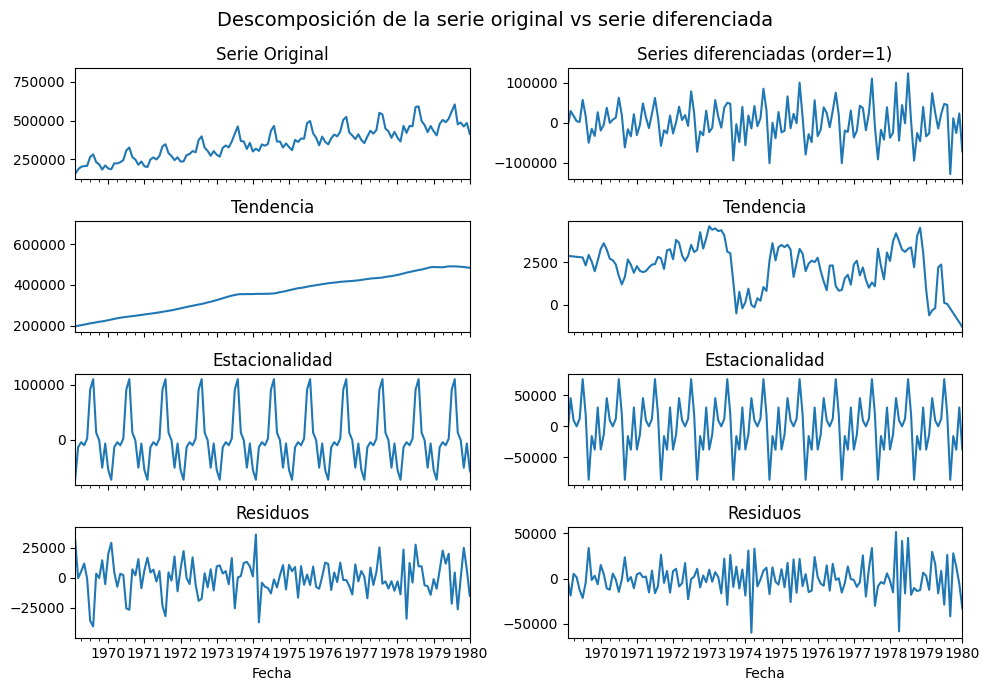

In [90]:
res_decompose=seasonal_decompose(df_new,model='additive',extrapolate_trend='freq')
res_descompose_diff_2=seasonal_decompose(df_diff_1,model='additive',extrapolate_trend='freq')
# Descomposicion de la serie original y la serie diferenicada
fig,axs=plt.subplots(nrows=4,ncols=2,figsize=(10,7),sharex=True)
res_decompose.observed.plot(ax=axs[0,0])
axs[0,0].set_title('Serie Original')
res_decompose.trend.plot(ax=axs[1,0])
axs[1, 0].set_title('Tendencia')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()
plt.show()

In [91]:
df_diff_1_12=df_train.diff().diff(12).dropna()
warnings.filterwarnings('ignore')
adfuller_result=adfuller(df_diff_1_12)
print(f'ADF Statistic:  {adfuller_result[0]}, p-value {adfuller_result[1]}')
kpss_result=kpss(df_diff_1_12)
print(f'KPSS Statistic _ {kpss_result[0]} , p.value {kpss_result[1]}')


ADF Statistic:  -4.387457230769957, p-value 0.0003123773271126916
KPSS Statistic _ 0.06291573421251052 , p.value 0.1


# **Modelo Arima - Sarimax**

In [92]:
modelo=SARIMAX(endog=df_train,order=(1,1,1),seasonal_order=(1,1,1,12))
modelo_res=modelo.fit(disp=0)
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Gasolinas   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Wed, 01 Nov 2023   AIC                           2722.103
Time:                                    21:28:58   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.38e+32. Standard errors may be unstable.
"""

In [93]:
# Prediccióm
predicciones_statsmodels=modelo_res.get_forecast(steps=len(df_train)).predicted_mean
predicciones_statsmodels.name='Predicciones_statsmodels'
display(predicciones_statsmodels.head())

1980-02-01    407504.056923
1980-03-01    473997.245798
1980-04-01    489983.091496
1980-05-01    485517.462855
1980-06-01    504445.207331
Freq: MS, Name: Predicciones_statsmodels, dtype: float64

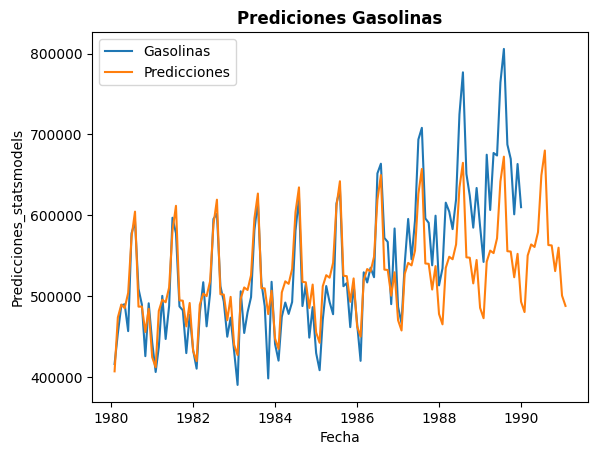

In [94]:
sns.lineplot(df_test)
sns.lineplot(predicciones_statsmodels,label='Predicciones')
plt.title('Prediciones Gasolinas',fontsize=12,weight='bold')
plt.show()

# **Skforecast**

In [96]:
modelo=Sarimax(order=(1,1,1),seasonal_order=(1,1,1,12))
modelo.fit(y=df_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Gasolinas   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1356.051
Date:                            Wed, 01 Nov 2023   AIC                           2722.103
Time:                                    22:28:15   BIC                           2736.040
Sample:                                01-01-1969   HQIC                          2727.763
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4972      0.134     -3.707      0.000      -0.760      -0.234
ma.L1         -0.0096      0.146     -0.066      0.947      -0.295       0.276
ar.S.L12       0.0465      0.162      0.288      0.774      -0.270       0.364
ma.S.L12      -0.3740      0.203     -1.847      0.065      -0.771       0.023
sigma2      3.291e+08   1.06e-09    3.1e+17      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   5.13   Jarque-Bera (JB):                18.12
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.38e+32. Standard errors may be unstable.
"""

In [97]:
# prediction
predicciones_skforecast=modelo.predict(steps=len(df_test))
display(predicciones_skforecast.head())

,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855
1980-06-01,504445.207331


In [106]:
predicciones_statsmodels.head()

1980-02-01    407504.056923
1980-03-01    473997.245798
1980-04-01    489983.091496
1980-05-01    485517.462855
1980-06-01    504445.207331
Freq: MS, Name: Predicciones_statsmodels, dtype: float64

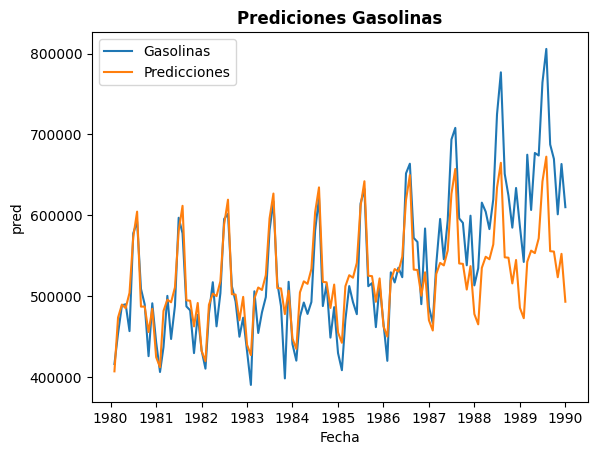

In [108]:
sns.lineplot(df_test)
sns.lineplot(predicciones_skforecast['pred'],label='Predicciones')
plt.title('Prediciones Gasolinas',fontsize=12,weight='bold')
plt.show()

# **MODELO ARIMA**

In [109]:
# Modelo SARIMAX
modelo=ARIMA(order=(1,1,1),seasonal_order=(1,1,1,12))
modelo.fit(y=df_train)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.749
Date:                            Thu, 02 Nov 2023   AIC                           2723.498
Time:                                    00:15:29   BIC                           2740.223
Sample:                                01-01-1969   HQIC                          2730.290
                                     - 01-01-1980                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -474.5820   1101.722     -0.431      0.667   -2633.917    1684.753
ar.L1         -0.4896      0.138     -3.554      0.000      -0.760      -0.220
ma.L1         -0.0211      0.151     -0.139      0.889      -0.317       0.275
ar.S.L12       0.0545      0.164      0.331      0.740      -0.268       0.377
ma.S.L12      -0.3841      0.204     -1.884      0.060      -0.784       0.015
sigma2      3.289e+08      0.002   1.84e+11      0.000    3.29e+08    3.29e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.90   Jarque-Bera (JB):                18.55
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.39e+27. Standard errors may be unstable.
"""

In [110]:
predicciones_pdmarima=modelo.predict(len(df_test))
predicciones_pdmarima.name='predicciones_pdmarima'
display(predicciones_pdmarima.head())

1980-02-01    406998.311377
1980-03-01    472944.444483
1980-04-01    488389.125288
1980-05-01    483432.075696
1980-06-01    501807.155658
Freq: MS, Name: predicciones_pdmarima, dtype: float64

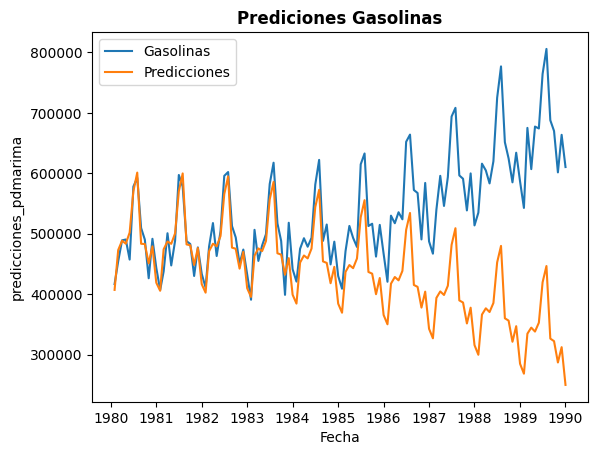

In [111]:
sns.lineplot(df_test)
sns.lineplot(predicciones_pdmarima,label='Predicciones')
plt.title('Prediciones Gasolinas',fontsize=12,weight='bold')
plt.show()

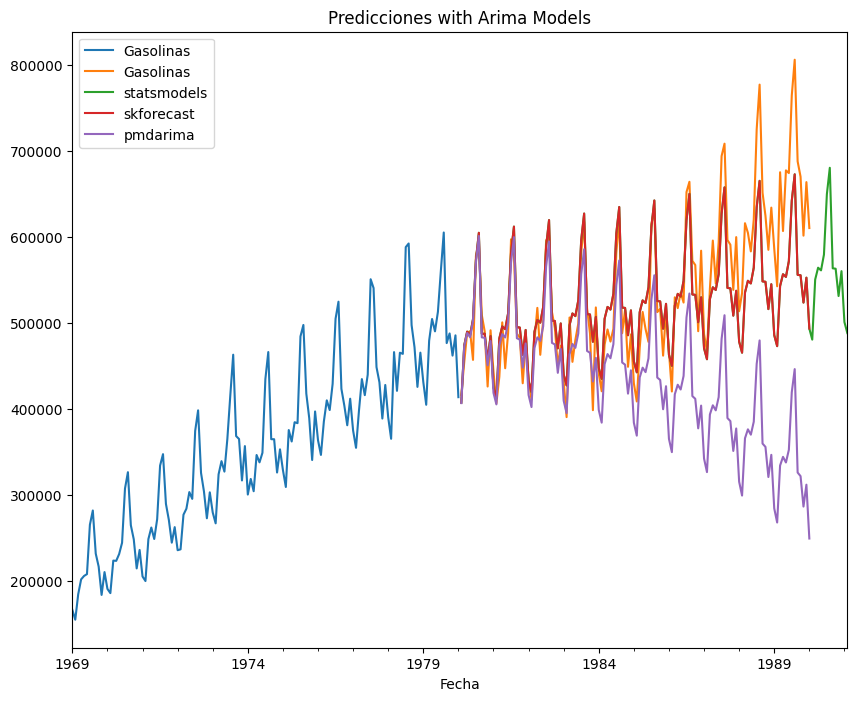

In [113]:
fig,ax=plt.subplots(figsize=(10,8))
df_train.plot(ax=ax,label='train')
df_test.plot(ax=ax,label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predicciones with Arima Models')
ax.legend()
plt.show()

# **Forecasting SARIMAX**

In [120]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
             )
forecaster.fit(y=df_train['Gasolinas'], suppress_warnings=True)
predicciones=forecaster.predict(steps=len(df_test))
predicciones.head()

1980-02-01    407504.056923
1980-03-01    473997.245798
1980-04-01    489983.091496
1980-05-01    485517.462855
1980-06-01    504445.207331
Freq: MS, Name: pred, dtype: float64

In [122]:
df_new.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Gasolinas
Fecha,
1969-01-01,166875.2129
1969-02-01,155466.8105
1969-03-01,184983.6699
1969-04-01,202319.8164
1969-05-01,206259.1523


In [125]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )
metrica, predicciones = backtesting_sarimax(
                            forecaster            = forecaster,
                            y                     = df_new['Gasolinas'],
                            initial_train_size    = len(df_train),
                            fixed_train_size      = False,
                            steps                 = 12,
                            metric                = 'mean_absolute_error',
                            refit                 = True,
                            n_jobs                = "auto",
                            suppress_warnings_fit = True,
                            verbose               = True,
                            show_progress         = True
                        )

print(f"Metrica (mean absolute error): {metrica}")
display(predicciones.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02-01 00:00:00 --

  0%|          | 0/10 [00:00<?, ?it/s]

Metrica (mean absolute error): 19611.236352170446


,pred
1980-02-01,407504.056923
1980-03-01,473997.245798
1980-04-01,489983.091496
1980-05-01,485517.462855


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


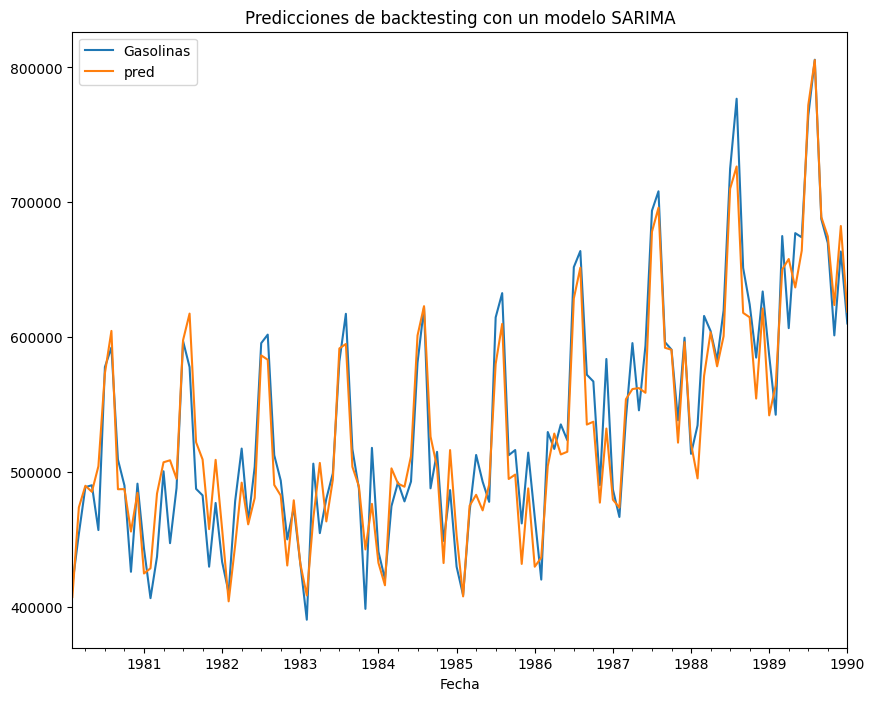

In [126]:
fig,ax=plt.subplots(figsize=(10,8))
df_new.loc[fin_train:].plot(ax=ax, label='test')
predicciones.plot(ax=ax)
ax.set_title('Predicciones de backtesting con un modelo SARIMA')
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


Fechas entrenamiento : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Fechas validacion    : 1976-02-01 00:00:00 --- 1984-01-01 00:00:00  (n=96)
Fechas test          : 1984-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=72)


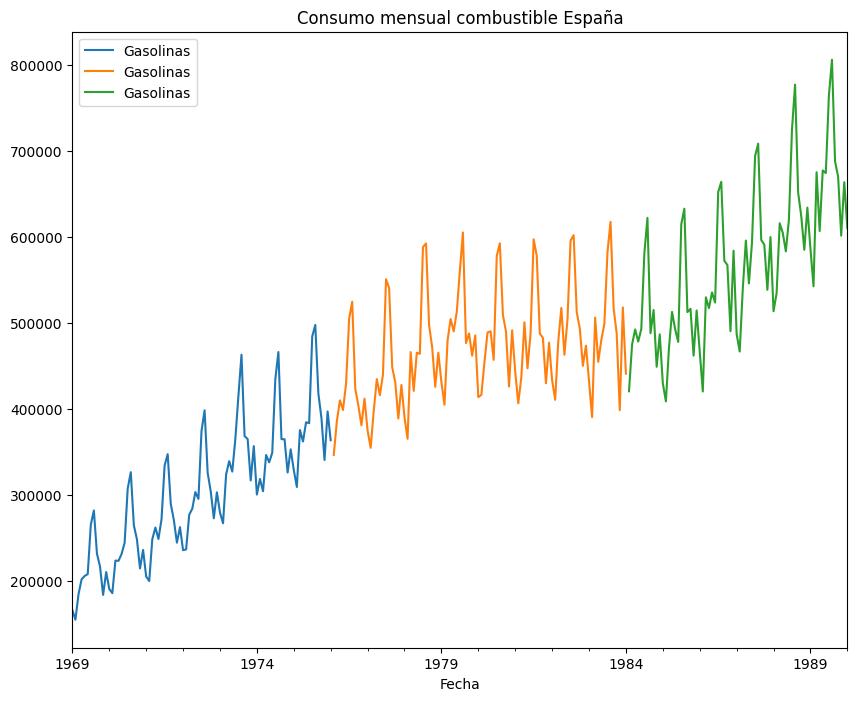

In [128]:
fin_train = '1976-01-01 23:59:59'
fin_val = '1984-01-01 23:59:59'
print(
    f"Fechas entrenamiento : {df_new.index.min()} --- {df_new.loc[:fin_train].index.max()}  "
    f"(n={len(df_new.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {df_new.loc[fin_train:].index.min()} --- {df_new.loc[:fin_val].index.max()}  "
    f"(n={len(df_new.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {df_new.loc[fin_val:].index.min()} --- {df_new.index.max()}  "
    f"(n={len(df_new.loc[fin_val:])})"
)

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 8))
df_new.loc[:fin_train].plot(ax=ax, label='entrenamiento')
df_new.loc[fin_train:fin_val].plot(ax=ax, label='validación')
df_new.loc[fin_val:].plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend()
plt.show()

In [130]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = df_new['Gasolinas'].loc[:fin_val],
                        param_grid            = param_grid,
                        steps                 = 12,
                        refit                 = True,
                        metric                = 'mean_absolute_error',
                        initial_train_size    = len(df_train),
                        fixed_train_size      = False,
                        return_best           = False,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )

resultados_grid.head(5)

Number of models compared: 45.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


params grid:   0%|          | 0/45 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
16,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897507,"(0, 1, 1)","(1, 1, 1, 12)",n
15,"{'order': (0, 1, 1), 'seasonal_order': (1, 1, ...",18789.897507,"(0, 1, 1)","(1, 1, 1, 12)",None
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376861,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",19897.376861,"(1, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",20176.735883,"(2, 1, 1)","(1, 1, 1, 12)",n


In [131]:
modelo = auto_arima(
            y                 = df_new['Gasolinas'].loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=3903.204, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3942.897, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3846.786, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3840.318, Time=0.97 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3873.797, Time=0.45 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=3841.882, Time=1.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3841.572, Time=4.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=3852.231, Time=0.68 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3842.593, Time=3.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=3904.615, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=3834.135, Time=0.58 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3866.187, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=3835.564, Time=0.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3835.160, Time=1.86 sec
 ARIMA(1,1,1)(1,1,0

In [132]:
from io import StringIO
import contextlib
import re
buffer = StringIO()
with contextlib.redirect_stdout(buffer):
    auto_arima(
            y                 = df_new['Gasolinas'].loc[:fin_val],
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = None, # El algoritmo determina 'd'
            D                 = None, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )
trace_autoarima = buffer.getvalue()
pattern = r'ARIMA\((\d+),(\d+),(\d+)\)\((\d+),(\d+),(\d+)\)\[(\d+)\]\s+(intercept)?\s+:\s+AIC=([\d\.]+), Time=([\d\.]+) sec'
matches = re.findall(pattern, trace_autoarima)
results = pd.DataFrame(matches, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'm', 'intercept', 'AIC', 'Time'])
results['order'] = results[['p', 'd', 'q']].apply(lambda x: f"({x[0]},{x[1]},{x[2]})", axis=1)
results['seasonal_order'] = results[['P', 'D', 'Q', 'm']].apply(lambda x: f"({x[0]},{x[1]},{x[2]},{x[3]})", axis=1)
results = results[['order', 'seasonal_order', 'intercept', 'AIC', 'Time']]
results.sort_values(by='AIC').reset_index(drop=True)

,order,seasonal_order,intercept,AIC,Time
0,"(1,1,1)","(0,1,1,12)",,3834.135,0.57
1,"(2,1,0)","(0,1,1,12)",,3834.277,0.44
2,"(0,1,2)","(0,1,1,12)",,3834.320,0.43
3,"(1,1,1)","(0,1,2,12)",,3835.160,2.80
4,"(1,1,1)","(0,1,1,12)",intercept,3835.455,0.60
5,"(1,1,1)","(1,1,1,12)",,3835.564,0.55
6,"(2,1,1)","(0,1,1,12)",,3836.104,1.17
7,"(1,1,2)","(0,1,1,12)",,3836.107,0.78
8,"(1,1,1)","(1,1,2,12)",,3836.443,3.60
9,"(1,1,0)","(0,1,1,12)",,3836.696,0.30
